# Topic: Image Classification by Semi-Supervised Learning

Pengyuan (Frank) Shi, p23shi

# Abstract

In this project, we tried to solve a weakly supervised classification problem, that is, in a dataset with $N$ samples, only $M$ samples have groundtruth label, and $N-M$ samples are unlabeled ($M << N$). The key workaround is to find an effective method to leverage the large amount of unlabeled data.

Particularly, we implemented and experimented with two motivated methods to construct a new objective component in the loss function, which utilized the unlabeled images. The general idea is to utilize the consistency of augmented versions of the same image (i.e. self augmentation loss). We experimented with the two methods on the cifar10 dataset, which contains 50000 training images (32 x 32 x 3) and 10000 testing images with 10 different classes. We experiemented the two methods with 250 label samples (i.e. 25 ground truth labels per class) and 4000 label samples seperately. We found the two methods have impressive improvements on the testing accuracy.

The report is structured as the following sections:
1. Setup, Functions and Classes Definition
2. Supervised Training Only (Do Not Use Unlabeled Data)
3. Method 1 - Prediction Consistency Loss (Motivated from FixMatch)
4. Method 2 - Contrastive Loss (Motivated from SimCLR)
5. Discussion and Conclusion

Note on submission: I have submitted the cifar10 data in the zip file (in pickle format). It is identical to the version downloaded from tochvision.

# Setup, Functions and Classes Definition

#  Code Libraries
All libraries are pytorch standard and can be installed from anaconda

We use model archetecture (ResNet18) and Cifar10 Dataset from torchvision

Pytorch is used for building and training the model

matplotlib is used to display training progress plots 

In [1]:
import torch
import random
import numpy as np
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from IPython.display import Image 

In [2]:
torch.manual_seed(484)
random.seed(484)
np.random.seed(484)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# classes defined in cifar10
classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')
test_acc_interval = 10

cuda


This is the model used for the supervised learning section and Method 1. It is basically an optimized ResNet18 for cifar10. 
The original ResNet18 was implemented for ImageNet, which has images with 224 x 224 shape. cifar10 only has 32 x 32 images, the first convolutional layer is changed to kernel size 3 from 7 and the maxpooling layer is removed. For method 2 model, it has a similar structure as this one (ResNet18 based), it will be defined in a later cell.
ResNet Paper: https://arxiv.org/abs/1512.03385

In [4]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.resnet18 = models.resnet18(pretrained=False)        
        self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, 
                                        stride=1, padding=1, bias=False)
        self.resnet18.bn1 = nn.BatchNorm2d(64)
        self.resnet18.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        #x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1) # B X 512
        x = self.resnet18.fc(x)
    
        return x

This function will return a split of labeled subset and unlabeled subet of data. The labeled data is distributed evenly within each class and the unlabeled data is just the entire dataset (if we drop the labels of labeled data, then it becomes unlabeled).   

In [5]:
def label_unlabel_split(labels, num_labeled=4000, num_classes=10):
    assert num_labeled % num_classes == 0
    l_per_class = num_labeled // num_classes
    l = np.array(labels)
    l_idx = []
    # unlabeled data is all data (including labeled data)
    ul_idx = np.array(range(len(l)))
    for i in range(num_classes):
        # for each class, choose the same number of labels
        idx = np.where(l == i)[0]
        # randomly choose some labeled data
        idx = np.random.choice(idx, l_per_class, replace=False)
        l_idx.extend(idx)
    l_idx = np.array(l_idx)
    np.random.shuffle(l_idx)
    return l_idx, ul_idx

Here the dataset classes are defined, the labeled dataset is just a subset of the entire training data, and the unlabeled dataset is the entire training data except all labels are removed.

In [6]:
class CIFAR10Labeled(datasets.CIFAR10):
    def __init__(self, root, l_indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if l_indexs is not None:
            self.data = self.data[l_indexs]
            self.targets = np.array(self.targets)[l_indexs].tolist()

class CIFAR10UnLabeled(datasets.CIFAR10):
    def __init__(self, root, l_indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if l_indexs is not None:
            self.data = self.data[l_indexs]
            self.targets = [-1 for _ in l_indexs]
        else:
            self.targets = [-1 for _ in range(len(self.targets))]

First, we want to have some understanding of the dataset. One sample from the training data is displayed. Also, the training data's mean and standard deviation are calculated for normalizing data later.

Files already downloaded and verified
sample with class deer


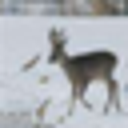

train dataset mean: [0.49139974 0.4821585  0.44653085]
train dataset std: [0.20230086 0.19941278 0.20096162]
train dataset number of samples: 50000


In [7]:
base_transform = transforms.Compose([transforms.ToTensor()])
to_pil = transforms.ToPILImage()
base_dataset = torchvision.datasets.CIFAR10(
    root='./images', train=True,
    download=True, transform=base_transform
)
demo_img, demo_label = base_dataset[20]
demo_img = to_pil(demo_img).resize((128, 128))
print(f"sample with class {classes[demo_label]}")
display(demo_img)
base_train_loader = torch.utils.data.DataLoader(
    base_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=1
)
train_mean = 0.
train_std = 0.
train_n_samples = 0.
for data in base_train_loader:
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    train_mean += data.mean(2).sum(0) / len(base_dataset)
    train_std += data.std(2).sum(0) / len(base_dataset)
    train_n_samples += batch_samples

assert train_n_samples == len(base_dataset)
print("train dataset mean:", train_mean.numpy())
print("train dataset std:", train_std.numpy())
print("train dataset number of samples:", round(train_n_samples))

The test function will evaluate a model's prediction accuracy on the testing dataset, it is used for all methods introduced in this project.

In [8]:
def test(net, testloader, verbose=True, classifer=None):
    net.eval()
    if classifer is not None:
        classifer.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    correct = 0
    total = 0

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            if classifer is None:
                outputs = net(images)
            else:
                outputs = classifer(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    if verbose:
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
        print(f'Average accuracy of the network on test images: \
                {round(100 * correct / total, 2)} %')
    return round(100 * correct / total, 2)

# Supervised Training Only (Do Not Use Unlabeled Data)

The purpose of this section is just to set an upper bound and lower bound (i.e. baseline) for our proposed methods. It also provides a comparision that how well our methods are doing. We want to know how much the model can achieve when the all training data has labels (upper bound). We also want to know how much the model will achieve if the model is only trained on the labeled proportion, when the number of ground truth labels is much smaller than the training set size(ex. 250, 4000). This will give the baselines, which means our methods should have a better performance by utilizing the unlabeled proportion.

One training epoch for supervised learning only, where we called the "trivial" method because it does not use any unlabeled data (i.e. the model is only trained on the labeled subset)

In [9]:
def train_trivial(net, trainloader, optimizer, criterion, epoch_id):
    net.train()
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item() / len(trainloader)

Execute the supervised learning pipeline

In [10]:
def run_trivial(n_label=None, n_epochs=150, batch_size=128):
    # include some data augmentaion to improve generalization and 
    # avoid overfitting
    train_trainsform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=.2, hue=.1),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize(train_mean.numpy(), train_std.numpy())
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean.numpy(), train_std.numpy())
    ])

    if n_label: # if we label a proportion of the dataset 
        
        train_labeled_idxs, train_unlabeled_idxs = label_unlabel_split(
            base_dataset.targets,
            num_labeled=n_label
        )

        train_labeled_dataset = CIFAR10Labeled(
            root='./images',
            l_indexs=train_labeled_idxs,
            train=True,
            transform=train_trainsform
        )

        trainloader = torch.utils.data.DataLoader(
            train_labeled_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0
        )
    else: # all data has labels
        
        trainset = torchvision.datasets.CIFAR10(
            root='./images',
            train=True,
            download=True,
            transform=train_trainsform
        )
        trainloader = torch.utils.data.DataLoader(
            trainset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0
        )

    testset = torchvision.datasets.CIFAR10(
        root='./images',
        train=False,
        download=True, 
        transform=test_transform
    )    

    testloader = torch.utils.data.DataLoader(
        testset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.03,
                          momentum=0.9, weight_decay=5e-4)
    # learning rate scheduler for adjusting the learning rate
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=n_epochs
    )
    
    test_acc = []
    # start learning
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        train_trivial(net, trainloader, optimizer, criterion, epoch)
        if (epoch + 1) % test_acc_interval == 0:
            test_acc.append(test(net, testloader, verbose=False))
        scheduler.step()
    test(net, testloader, verbose=True)
    return net, test_acc

Training on 250 labeled data only

In [11]:
net, test_acc_250_trivial = run_trivial(250, n_epochs=300) 
torch.save(net.state_dict(), "resnet18-250-trivial.pt")

# Testing results on last epoch:
# Accuracy for class: plane is 44.5 %
# Accuracy for class: car   is 45.7 %
# Accuracy for class: bird  is 21.5 %
# Accuracy for class: cat   is 23.8 %
# Accuracy for class: deer  is 25.5 %
# Accuracy for class: dog   is 28.4 %
# Accuracy for class: frog  is 50.0 %
# Accuracy for class: horse is 34.0 %
# Accuracy for class: ship  is 53.5 %
# Accuracy for class: truck is 38.3 %
# Average accuracy of the network on test images: 36.52 %


Training on 4000 labeled data only (uncomment to run)

In [12]:
net, test_acc_4000_trivial = run_trivial(4000, n_epochs=300) 
torch.save(net.state_dict(), "resnet18-4000-trivial.pt")

# Testing results on last epoch:
# Accuracy for class: plane is 78.2 %
# Accuracy for class: car   is 88.5 %
# Accuracy for class: bird  is 65.3 %
# Accuracy for class: cat   is 51.8 %
# Accuracy for class: deer  is 66.7 %
# Accuracy for class: dog   is 65.4 %
# Accuracy for class: frog  is 85.4 %
# Accuracy for class: horse is 79.2 %
# Accuracy for class: ship  is 89.1 %
# Accuracy for class: truck is 86.1 %
# Average accuracy of the network on test images: 75.57 %

Training on entire training set (all data has labels)

In [13]:
net, test_acc_sup_trivial = run_trivial(n_epochs=300) 
torch.save(net.state_dict(), "resnet18-sup-trivial.pt")

# Testing results on last epoch:
# Accuracy for class: car   is 97.1 %
# Accuracy for class: bird  is 92.2 %
# Accuracy for class: cat   is 87.7 %
# Accuracy for class: deer  is 96.1 %
# Accuracy for class: dog   is 90.3 %
# Accuracy for class: frog  is 96.9 %
# Accuracy for class: horse is 95.5 %
# Accuracy for class: ship  is 97.5 %
# Accuracy for class: truck is 96.4 %
# Average accuracy of the network on test images: 94.49 %

plot the testing performances training

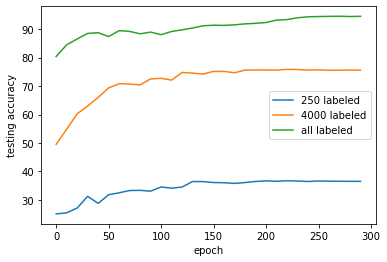

In [15]:
epochs = list(range(0, 300, test_acc_interval))
plt.plot(epochs, test_acc_250_trivial, label="250 labeled")
plt.plot(epochs, test_acc_4000_trivial, label="4000 labeled")
plt.plot(epochs, test_acc_sup_trivial, label="all labeled")
plt.xlabel("epoch")
plt.ylabel("testing accuracy")
plt.legend()
plt.show()

Discussion: We can see that if we only train the model on the labeled subset, it will acheive poor performance, especially when the number of labeled data is small, such as 250. And we can now set the upper bound of our methods to 94.5\%, and the baseline for 250-label and 4000-label to 36.5\% and 75.6\% respectively.

# Method 1 - Prediction Consistency Loss (Motivated from FixMatch)

In this section, we experience adding a prediction consistency loss on the unlabeled data when training the model. It is motivated from the paper:  FixMatch: Simplifying Semi-Supervised Learning with Consistency and Confidence.

FixMatch paper: https://arxiv.org/abs/2001.07685

The key idea is the following: Given an image $I$ and its $k$ augmented versions $\{I_1, I_2, \dots, I_n\}$, the model should predict all $\{I_1, I_2, \dots, I_n\}$ as the same class because they are essentially augmented from the same image.

In our implementation, we take this idea and construct one weakly augmented image $I_w$ and one strongly augmented image $I_s$ from the unlabeled sample $I$. We take the model's one-hot prediction on $I_w$ as the Pseudo-label for $I_s$ (i.e. we treat the one-hot prediction of $I_w$ as the groundtruth label for $I_s$). Then, the prediction consistency loss is the cross entropy of prediction on $I_s$ and one-hot prediction on $I_w$ (target). Formally, the prediction consistency loss on one unlabeled sample $I$ can be represented as the following:
$$\ell_u^I = \mathbb{1}(\max(q_I) \geq \tau)\ \text{H}(\text{argmax}(q_I), p_\theta(y | I_s)) $$ 

where $q_I = p_\theta(y | I_w)$ is the model prediction on the weakly augmented version of $I$, H is the cross entropy function 

Note that the $\mathbb{1}(\max(q_I) \geq \tau)$ part is a add-on mask, it will turn off the entropy part if the highest confidence of the model on $I_w$ is lower than a hyperparameter $\tau$. The intuition is that, if the model is unconfident on the weakly augmented version, we shouldn't force it to be unconfident on the strongly augmented version.

Apart from the prediction consistency loss, the usual supervised training cross entropy loss is also used in the training.

The transform contains weak and strong augmentation for unlabeled data. Strong augmentation has one more RandAugment transformation.

In [16]:
class FixMatchUnlabelledTransform():
    def __init__(self, norm_mean, norm_std, normalize=True):
        self.weak_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=4,
                                  padding_mode='reflect')])
        self.strong_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=4,
                                  padding_mode='reflect'),
            transforms.RandAugment(num_ops=2, magnitude=15)])
        
        if normalize:    
            self.normalize = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_std)])
        else:
            self.normalize = transforms.Compose([
                transforms.ToTensor()])

    def __call__(self, x):
        weak_aug_data = self.weak_aug(x)
        strong_aug_data = self.strong_aug(x)
        return self.normalize(weak_aug_data), self.normalize(strong_aug_data)

Demo of the weak and strong augmentation on a training sample

Files already downloaded and verified
input image


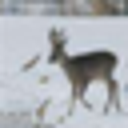

weak augmented image


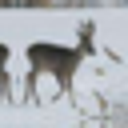

strong augmented image


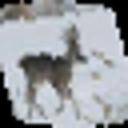

In [17]:
fixmatch_dataset = torchvision.datasets.CIFAR10(
    root='./images',
    train=True,
    download=True,
    transform=FixMatchUnlabelledTransform(
        train_mean.numpy(), train_std.numpy(), normalize=False
    )
)
(weak_aug_img, strong_aug_img), label = fixmatch_dataset[20]
weak_aug_img = to_pil(weak_aug_img).resize((128, 128))
strong_aug_img = to_pil(strong_aug_img).resize((128, 128))
print("input image")
display(demo_img)
print("weak augmented image")
display(weak_aug_img)
print("strong augmented image")
display(strong_aug_img)

The training pipeline is:
1. we take a batch of $b + 2\mu b$ images, with first b entries as the ones with ground truth labels, then next $\mu b$ entries as the weakly augmented versions of unlabeled images, finally $\mu b$ entries with the corresponding strongly augmented versions of unlabeled images.
2. feed the whole batch to the model
3. extract the predictions, using the one-hot of prediction on weakly augmented entries as targets for stronly augmented entries.
4. calculate two loss, loss_labeled and loss_unlabeled with multiplying with a hyperparameter weight $\lambda$ for the unlabeled loss, here we use $\lambda = 1$
5. backprop and update

Note, in our implementation, we use $\mu = 7$ as introduced in the FixMatch paper

In [18]:
def train_fixmatch(net, train_labeledloader,
                   train_unlabeledloader, optimizer, 
                   epoch_id, lambda_unlabeled,
                   confidence_threshold):

    net.train()
    running_loss = 0.0
    total_loss = 0.0
    n_iter_labeled = len(train_labeledloader)
    n_iter_unlabeled = len(train_unlabeledloader)
    m = n_iter_unlabeled // n_iter_labeled
    unlabeled_batches = iter(train_unlabeledloader)
    running_loss = 0.0 
    running_loss_labeled = 0.0
    running_loss_unlabeled = 0.0
    
    for i in range(n_iter_unlabeled):
        
        torch.cuda.synchronize()
        
        if i % n_iter_labeled == 0:
            labeled_batches = iter(train_labeledloader)

        optimizer.zero_grad()
        
        labeled_img, labels = next(labeled_batches)
        (unlabeled_weak_aug,
         unlabeled_strong_aug), _ = next(unlabeled_batches)
        
        labels = labels.to(device)
        
        labeled_batch_size = len(labeled_img)
        
        # concatenate all data into one batch to speed up
        inputs = torch.cat(
            (labeled_img,
             unlabeled_weak_aug,
             unlabeled_strong_aug
            )
        ).to(device)
        
        logits = net(inputs)
        
        # extract the prediction logits
        
        logits_labeled = logits[:labeled_batch_size]
        
        (logits_unlabeled_weak_aug, 
         logits_unlabeled_strong_aug) = logits[labeled_batch_size:].chunk(2)
        
        logits_unlabeled_weak_aug = logits_unlabeled_weak_aug.detach()
        
        # calculate labeled loss
        loss_labeled = F.cross_entropy(
            logits_labeled,
            labels,
            reduction='mean'
        )
        
        # get the Pseudo-label 
        predictions_weak_aug = torch.softmax(
            logits_unlabeled_weak_aug, dim=-1
        )
        max_probs, targets_unlabeled = torch.max(
            predictions_weak_aug, dim=-1
        )
        mask = torch.ge(max_probs, confidence_threshold).float()
        
        loss_unlabeled = (
            F.cross_entropy(
                logits_unlabeled_strong_aug,
                targets_unlabeled,
                reduction='none'
            ) * mask
        ).mean()
        
        loss = loss_labeled + lambda_unlabeled * loss_unlabeled
        
        loss.backward()
        optimizer.step()
        
        running_loss_labeled += loss_labeled.item() / n_iter_unlabeled
        running_loss_unlabeled += loss_unlabeled.item() / n_iter_unlabeled
        running_loss += loss.item() / n_iter_unlabeled

    print(f'[{epoch_id + 1}] loss: {running_loss:.3f}, \
          labeled loss {running_loss_labeled:.3f}, \
          unlabeled loss {running_loss_unlabeled:.3f}')
    return running_loss

Executing method 1, which uses exactly the model in supervised only training and same hyperparmters (learning rate, epochs, momentum, etc).  

In [19]:
def run_fixmatch(n_label=None, n_epochs=300,
                 batch_size_labeled=32,
                 batch_size_unlabeled=224,
                 test_batch_size=64, lr=0.015):
    labeled_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            train_mean.numpy(), train_std.numpy()
        )
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            train_mean.numpy(), train_std.numpy()
        )
    ])
    
    train_labeled_idxs, train_unlabeled_idxs = label_unlabel_split(
            base_dataset.targets,
            num_labeled=n_label
    )
    
    train_labeled_dataset = CIFAR10Labeled(
            root='./images',
            l_indexs=train_labeled_idxs,
            train=True,
            transform=labeled_transform
    )
    
    train_unlabeled_dataset = CIFAR10UnLabeled(
            root='./images',
            l_indexs=train_unlabeled_idxs,
            train=True,
            transform=FixMatchUnlabelledTransform(
                train_mean.numpy(),
                train_std.numpy(),
                normalize=True
            )
    )
    
    train_labeledloader = torch.utils.data.DataLoader(
        train_labeled_dataset,
        batch_size=batch_size_labeled,
        shuffle=True, num_workers=0
    )
    
    train_unlabeledloader = torch.utils.data.DataLoader(
        train_unlabeled_dataset,
        batch_size=batch_size_unlabeled,
        shuffle=True,
        num_workers=0
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./images', train=False,
        download=True, transform=test_transform
    )    

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size,
        shuffle=False, num_workers=0
    )
    
    net = Net()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(), lr=lr,
        momentum=0.9, weight_decay=5e-4
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=n_epochs
    )

    test_acc = []
    running_loss = []
    for epoch in range(n_epochs):
        running_loss.append(
            train_fixmatch(
                net, train_labeledloader,
                train_unlabeledloader, optimizer,
                epoch, 1, 0.95
            )
        )
        if (epoch + 1) % test_acc_interval == 0:
            test_acc.append(test(net, testloader))
        scheduler.step()
    return net, test_acc, running_loss
        

Running method 1 with 250 labeled data

In [20]:
net, test_acc_250_fixmatch, train_loss_250_fixmatch = run_fixmatch(
    n_label=250, n_epochs=300
)
torch.save(net.state_dict(), "resnet18-250-fixmatch.pt")

[1] loss: 1.318, labeled loss 1.192, unlabeled loss 0.126
[2] loss: 0.528, labeled loss 0.218, unlabeled loss 0.310
[3] loss: 0.368, labeled loss 0.070, unlabeled loss 0.298
[4] loss: 0.314, labeled loss 0.043, unlabeled loss 0.271
[5] loss: 0.277, labeled loss 0.027, unlabeled loss 0.250
[6] loss: 0.289, labeled loss 0.037, unlabeled loss 0.252
[7] loss: 0.262, labeled loss 0.021, unlabeled loss 0.241
[8] loss: 0.269, labeled loss 0.028, unlabeled loss 0.240
[9] loss: 0.253, labeled loss 0.021, unlabeled loss 0.232
[10] loss: 0.235, labeled loss 0.016, unlabeled loss 0.218
Accuracy for class: plane is 11.8 %
Accuracy for class: car   is 36.3 %
Accuracy for class: bird  is 19.7 %
Accuracy for class: cat   is 1.8 %
Accuracy for class: deer  is 67.3 %
Accuracy for class: dog   is 31.0 %
Accuracy for class: frog  is 48.5 %
Accuracy for class: horse is 8.5 %
Accuracy for class: ship  is 74.4 %
Accuracy for class: truck is 30.6 %
Average accuracy of the network on test images: 32.99 %
[11] 

We can see a nicely decreasing training loss

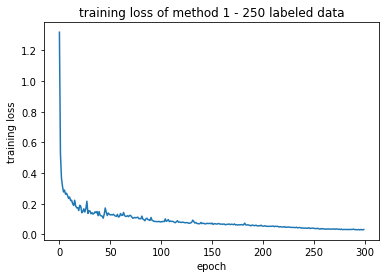

In [22]:
epochs = list(range(0, 300))
plt.plot(epochs, train_loss_250_fixmatch)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title("training loss of method 1 - 250 labeled data")
plt.show()

Running method 1 with 4000 labeled data

In [23]:
net, test_acc_4000_fixmatch, train_loss_4000_fixmatch = run_fixmatch(
    n_label=4000, n_epochs=300
)
torch.save(net.state_dict(), "resnet18-4000-fixmatch.pt")

[1] loss: 2.078, labeled loss 2.065, unlabeled loss 0.014
[2] loss: 1.651, labeled loss 1.643, unlabeled loss 0.007
[3] loss: 1.499, labeled loss 1.485, unlabeled loss 0.014
[4] loss: 1.391, labeled loss 1.349, unlabeled loss 0.041
[5] loss: 1.258, labeled loss 1.195, unlabeled loss 0.063
[6] loss: 1.192, labeled loss 1.104, unlabeled loss 0.088
[7] loss: 1.087, labeled loss 0.980, unlabeled loss 0.107
[8] loss: 1.034, labeled loss 0.910, unlabeled loss 0.124
[9] loss: 0.952, labeled loss 0.819, unlabeled loss 0.133
[10] loss: 0.913, labeled loss 0.759, unlabeled loss 0.154
Accuracy for class: plane is 74.7 %
Accuracy for class: car   is 82.7 %
Accuracy for class: bird  is 23.6 %
Accuracy for class: cat   is 9.3 %
Accuracy for class: deer  is 55.7 %
Accuracy for class: dog   is 70.9 %
Accuracy for class: frog  is 66.7 %
Accuracy for class: horse is 79.9 %
Accuracy for class: ship  is 58.1 %
Accuracy for class: truck is 89.6 %
Average accuracy of the network on test images: 61.12 %
[11]

We can see a nicely decreasing training loss

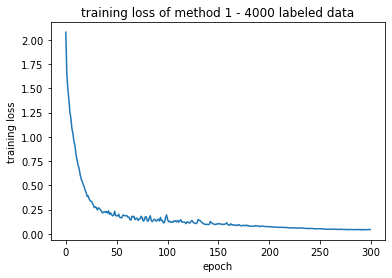

In [25]:
epochs = list(range(0, 300))
plt.plot(epochs, train_loss_4000_fixmatch)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title("training loss of method 1 - 4000 labeled data")
plt.show()

Let's compare the testing accuracy of all models we trained so far.
It is obvious that method 1 has a huge improvement, where the
testing accuracy on 250-labeled case improves from 36.5\% to 63.7\%,
and the testing accuracy on 4000-labeled case improves from 75.6\% to 92.6\%, almost close to the case when we have all labels!

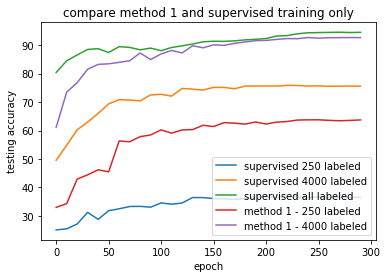

In [26]:
epochs = list(range(0, 300, test_acc_interval))
plt.plot(epochs, test_acc_250_trivial, label="supervised 250 labeled")
plt.plot(epochs, test_acc_4000_trivial, label="supervised 4000 labeled")
plt.plot(epochs, test_acc_sup_trivial, label="supervised all labeled")
plt.plot(epochs, test_acc_250_fixmatch, label="method 1 - 250 labeled")
plt.plot(epochs, test_acc_4000_fixmatch, label="method 1 - 4000 labeled")
plt.xlabel("epoch")
plt.ylabel("testing accuracy")
plt.title("compare method 1 and supervised training only")
plt.legend()
plt.show()

As we can see from the training results, the inclusion of prediction consistency loss makes a huge improvement by using the unlabeled data. Although it is one of the most simpliest way to construct the self augmentation loss, it is very effective. However, when there is only few labeled samples available, such as the 250 labels case, the model is still not applicable in practise because the accuracy is just between 60 - 70\%. This is because method 1 or FixMatch assumes that the confident pseudo-labels are correct, which is usually false when there is few samples with groundtruth labels , because the baseline is low.

# Method 2 - Contrastive Loss (Motivated from SimCLR)

In method 2, we experiment with a more general loss for unsupervised training, which is the constrastive loss. It does not rely one the assumption of correctness of pseudo-labels from method 1, but focus on the latent representation, or the features of the input. Method 2 is motivated from the paper A Simple Framework for Contrastive Learning of Visual Representations (i.e. SimCLR).

SimCLR paper: https://arxiv.org/abs/2002.05709

The general idea of contrastive loss is that the latent representations of correlated images should have similar patterns. Similar to method 1, we construct two augmentations of an unlabeled image $I$ (not necessarily to be weak and strong augmentations), call them $I_1$ and $I_2$. Then, $I_1$ and $I_2$ are a postive pair because they are correlated (augmented from the same image). For a differnt image $J$, which is independent from $I$, we call $I_1$ and $J$ are a negative pair, because they are uncorrelated. Therefore, the objective of the model is to bring the latent representations of positive pair closer to each other.

To evaluate the similarity of two latent representations (i.e. vectors), we use cosine similarity, which can be represented formally by:
$$s_{i, j} = \frac{z_i^\top z_j} {\|z_i\|\  \|z_j\|} $$

When training, we only compute the constrasitve loss for postive pairs, for any positive pairs $(i, j)$, we define the loss to be $$\ell(i,j) = - \log \frac{\exp(s_{i, j} / \tau)} {\sum_{k=1}^{2N} \mathbb{1}_{[k\ne i]} \exp(s_{i, k} / \tau)  }$$
Note that $2N$ is the number of augmented images, each sample has two augmented versions. And $\mathbb{1}_{[k\ne i]}$ is an indicator that has a value of 1 if $k \ne i$.

Thus, for the entire dataset of $N$ samples, we have the total contrastive loss to be

$$L = \frac{1}{2N} \sum_{k=1}^N [\ell(2k-1, 2k) + \ell(2k, 2k-1)]$$

The training pipeline is as follows:

1. First we construct the feature extractor as part of the model with a multi-layer perceptron, called projector that maps the features to a latent space
2. Training the feature extractor with the projector on unlabeled data with contrastive loss
3. After unsupervised training, we throw away the projector, and use another untrained linear layer as the classfier that maps the features to predictions
4. Fine-tuning the classfier on labeled data subset, use supervised training, with the feature extractor frozen
5. Combine the feature extractor and the classfier as the final model

First we define the model used in unsupervised training, where a ResNet18 is used as the feature extractor

In [27]:
class SimCLRNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.feature_extractor = models.resnet18(
            pretrained=False
        )   
        self.feature_extractor.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.feature_extractor.bn1 = nn.BatchNorm2d(64)
        self.feature_extractor.fc = nn.Identity() # we don't need the fully connected layer
        self.projector = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, hidden_dim)
        )
    
    def feature_encode(self, x):
        x = self.feature_extractor.conv1(x)
        x = self.feature_extractor.bn1(x)
        x = self.feature_extractor.relu(x)

        x = self.feature_extractor.layer1(x)
        x = self.feature_extractor.layer2(x)
        x = self.feature_extractor.layer3(x)
        x = self.feature_extractor.layer4(x)
        x = F.avg_pool2d(x, 4)
        
        feature = torch.flatten(x, 1) # B X 512
        return feature
        
    def forward(self, x):
        
        feature = self.feature_encode(x)
        hidden = self.projector(feature)
        return feature, hidden

This is the classfier used in supervised fine-tuning, it is just a combined model with the feature extractor and linear layer.

In [28]:
class SimCLRClassifier(nn.Module):
    def __init__(self, feature_encoder, 
                 input_dim=512, n_classes=10):
        super().__init__()
        self.feature_encoder = feature_encoder
        self.dense = nn.Linear(input_dim, n_classes)
    
    def forward(self, x):
        return self.dense(
            self.feature_encoder.feature_encode(x)
        )

The transform class similar to FixMatchTransform, which returns two augmented versions of the same image

In [29]:
class SimCLRUnlabelledTransform():
    def __init__(self, norm_mean, norm_std, normalize=True):
        if normalize:    
            self.normalize = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_std)])
        else:
            self.normalize = transforms.Compose([
                transforms.ToTensor()])

        self.aug = transforms.Compose([
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)],
                p=0.8),
            transforms.RandomGrayscale(p=0.2),
            self.normalize
        ])
        
    def __call__(self, x):
        aug_data_1 = self.aug(x)
        aug_data_2 = self.aug(x)
        
        return aug_data_1, aug_data_2

The contrastive loss implementation. From the loss formula above, we can see that the contrastive loss of a positve pair is similar to softmax (because the "exponential normalization") and cross entropy (because of the logarithm and we only focus on postive pairs). Therefore, we can restructured the implementation as below to utilize the cross entropy function from pytorch

In [30]:
def nce_loss(hidden_emb, t=0.5):
    hidden_emb = F.normalize(hidden_emb, dim=1)
    # cosine similarity scores
    hidden_similarity = (
        hidden_emb @ hidden_emb.t()
    ).clamp(min=1e-7) / t
    # hidden_similarity_ij = scores between i and j
    
    # the denominator should not include similarity with self
    # using the trick that exp(-BIG NUM) is approximately 0
    # torch.eye gives diagonal matrix with 1s on the diagonal

    hidden_similarity = hidden_similarity - torch.eye(
        hidden_similarity.shape[0]
    ).to(device) * 1e6
    
    # using cross entropy trick
    # here the target is represents the positive pairs
    # ex. first entry's target is the second entry
    # second entry's target is the first entry
    # so the target is [1, 0]
    # it is simply for disabling negative pairs when
    # computing the loss by cross entropy trick
    targets = torch.arange(hidden_emb.shape[0]) # [0, 1, 2, 3, ....]
    targets[::2] += 1  # [1, 1, 3, 3, ....], step 2 from 0
    targets[1::2] -= 1  # [1, 0, 3, 2, ....], step 2 from 1
    return F.cross_entropy(
        hidden_similarity, targets.long().to(device)
    )

Unsupervised training pipeline, note that we want the input batch to the model to be
$$[I_1^1, I_2^1, I_1^2, I_2^2, \dots]$$
where $I_i^j$ represents the $i$th augmented version of the $j$th sample $I^j$

In [31]:
def train_simclr_unlabeled(net, train_unlabeledloader, 
                           optimizer, scheduler, epoch_id):
    net.train()
    running_loss = 0.0
    for batch in train_unlabeledloader:
        
        batch = torch.stack(batch[0], dim=1)
        s = batch.shape
        data = batch.view(s[0] * 2, s[2], s[3], s[4]).to(device)

        optimizer.zero_grad()
        _, hidden_emb = net(data)
        loss = nce_loss(hidden_emb, 0.5)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() / len(train_unlabeledloader)
    
    print(f'[{epoch_id + 1}] loss: {running_loss:.3f}')
    return running_loss

Supervised fine-tuning, very similar to supervised training above.

In [32]:
def train_simclr_fine_tune(net, classifer, trainloader, 
                           criterion, optimizer, epoch_id):
    # set to train mode, but do not update the params
    net.train()
    classifer.train()
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item() / len(trainloader)
    print(f'[{epoch_id + 1}] loss: {total_loss:.3f}')

Execute method 2, note that we have two stages of training:

1. In the first stage, we do unsupervised training on the unlabeled dataset (which is the entire dataset), model is SimCLRNet
2. In the second stage, we do the supervised fine-tuning on the labeled training data, model is SimCLRClassifier and the feature extractor part is frozen.

Because the unsupervised training stage does not rely on any labels, one benefit is that we don't need to train the feature extractor from scratch for different number of labeled data. (i.e. we can fine-tune the model on 250 labeled data and 4000 labeled data seperately with one feature extractor).

In [33]:
def run_simclr(n_label=None, un_epochs=500, 
               fine_tune_epochs=100, batch_size_labeled=64, 
               batch_size_unlabeled=256, test_batch_size=64, 
               lr_encoder=0.3, lr_classifer=0.075, 
               skip_stage_1=False, simclr_path=""):
    
    train_labeled_idxs, train_unlabeled_idxs = label_unlabel_split(
                base_dataset.targets,
                num_labeled=n_label
    )
    
    running_loss_unlabeled = []
    
    if not skip_stage_1:
        
        train_unlabeled_dataset = CIFAR10UnLabeled(
            root='./images',
            l_indexs=train_unlabeled_idxs,
            train=True,
            transform=SimCLRUnlabelledTransform(
                train_mean.numpy(),
                train_std.numpy(),
                normalize=True
            )
        )
    
        train_unlabeledloader = torch.utils.data.DataLoader(
            train_unlabeled_dataset,
            batch_size=batch_size_unlabeled,
            shuffle=True,
            num_workers=0,
            drop_last=True
        )

        net = SimCLRNet()
        net.to(device)
        optimizer_unlabeled = optim.SGD(
            net.parameters(), lr=lr_encoder, 
            momentum=0.9, weight_decay=1.0e-6
        )
        scheduler_unlabeled = optim.lr_scheduler.CosineAnnealingLR(
            optimizer_unlabeled, 
            T_max=un_epochs * len(train_unlabeledloader), 
            eta_min=1e-3
        )  
    
        # stage 1, unlabeled constrastive training
        
        for epoch in range(un_epochs):
            running_loss_unlabeled.append(
                train_simclr_unlabeled(
                    net, 
                    train_unlabeledloader,
                    optimizer_unlabeled,
                    scheduler_unlabeled, 
                    epoch
                )
            )
            # save the model
            if un_epochs >= 20 and (epoch + 1) % (un_epochs // 20) == 0:
                torch.save(
                    net.state_dict(), f"resnet18-simclr1_{epoch}.pt"
                )
    else:
        net = SimCLRNet()
        # simclr_path should be valid 
        net.load_state_dict(torch.load(simclr_path))
        net.to(device)
    
    # stage 2, fine-tuning on labeled data
    labeled_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(train_mean.numpy(), train_std.numpy())
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean.numpy(), train_std.numpy())
    ])
    
    train_labeled_dataset = CIFAR10Labeled(
            root='./images',
            l_indexs=train_labeled_idxs,
            train=True,
            transform=labeled_transform
    )
    
    train_labeledloader = torch.utils.data.DataLoader(
        train_labeled_dataset,
        batch_size=batch_size_labeled,
        shuffle=True, num_workers=0
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./images', train=False,
        download=True, transform=test_transform)    

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size,
        shuffle=False, num_workers=0)
    
    #net.requires_grad = False
    classifer = SimCLRClassifier(net)
    classifer.to(device)

    for param in classifer.feature_encoder.parameters():
        param.requires_grad = False

    parameters = [
        param for param in classifer.parameters() \
        if param.requires_grad is True
    ]  # trainable parameters.
    optimizer_labeled = optim.SGD(parameters,
                                  lr=lr_classifer,
                                  momentum=0.9,
                                  weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler_labeled = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_labeled, T_max=fine_tune_epochs
    )
        
    # stage 2, unlabeled constrastive training
    running_loss_fine_tune = []
    test_acc = []

    for epoch in range(fine_tune_epochs):
        running_loss_fine_tune.append(
            train_simclr_fine_tune(net, classifer,
                                   train_labeledloader,
                                   criterion, optimizer_labeled, 
                                   epoch)
        )
        if (epoch + 1) % test_acc_interval == 0:
            test_acc.append(
                test(net,
                     testloader,
                     classifer=classifer)
            )
        scheduler_labeled.step()
    
    test(net, testloader, classifer=classifer)
    
    return (net, classifer,
            running_loss_unlabeled,
            running_loss_fine_tune,
            test_acc)
        

Running method 2 on 250 labeled data

In [34]:
(net, classifer, train_loss_unlabeled_simclr_250, 
 train_loss_simclr_fine_tune_250, test_acc_250_simclr) = run_simclr(
    n_label=250, un_epochs=500, fine_tune_epochs=100
)
torch.save(net.state_dict(), "resnet18-encoder-simclr.pt")
torch.save(classifer.state_dict(), "resnet18-250-classifer-simclr.pt")

Running method 2 on 4000 labeled data, we can skip and reuse feature extractor from the above   because the unlabeled dataset is the same

In [35]:
(net, classifer, train_loss_unlabeled_simclr_4000, 
 train_loss_simclr_fine_tune_4000, test_acc_4000_simclr) = run_simclr(
    n_label=4000,
    skip_stage_1=True,
    simclr_path="resnet18-encoder-simclr.pt",
    fine_tune_epochs=100
)
torch.save(classifer.state_dict(), "resnet18-4000-classifer-simclr.pt")

We trained method 2 on a linux sever, and the results are concluded in the table below

|                          | 250 labels | 4000 labels |
|--------------------------|------------|-------------|
| Supervised training only | 36.52      | 75.57       |
| Method 1 (FixMatch)      | 63.72      | 92.63       |
| Method 2 (SimCLR)        | 77.49      | 83.59       |

Method 1 is better than Method 2 on the 4000 labels case, but poorer than Method 2 on the 250 labels case. We can make the following hypothesis from the experiements:

When only a few labels are availables, it is very difficult for the model to learn a reasonable latent representation of the input if we focus on the prediction only, which heavily depends on the correctness of pseudo-labels (method 1). However, if we focus on latent representation that the model learnt (method 2), the number of labels is not a problem any more, but we lose the benefit of labels because the feature extractor cannot leverage the availability of labeled samples in training (i.e. the feature extractor is trained purely from unlabeled images). When more labeled data is available, method 1 is more useful because the model can learn the latent representation effectively while looking at the labeled data, which can significantly improve the correctness of pseudo-labels.

# Discussion and Conclusion

Comparing method 2 with method 1, we can see that method 2 has more improvement on the small labeled subset case (ex. 250 labels). However, method 1 has more improvement on the medium size labeled subset case (ex. 4000 labels). The key difference is that method 2 is focusing on the latent representatations of images, while method 1 is focusing on the predictions. However, they are both leveraging the consistency of augmented data, which is the key in weakly supervised learning. 

Finally, we noticed that the results from our experiements have difference from the reported results of the referenced papers. This might due to we are using different model architectures, augmentation functions, and hyperparameters because of compute resource limitation. We also found that weakly supervised learning is highly depend on the augmentation functions. If we change the first augmentation in SimCLRUnlabelledTransform from RandomResizedCrop to RandomCrop with padding (used in method 1), the performance will drop over 20%. Therefore, we have to be careful to choose the correct augmentations when doing weakly supervised learning with different methods.

# Improvements

There are further improvements we can make. The research group of SimCLR announced SimCLRv2 
(Big Self-Supervised Models are Strong Semi-Supervised Learners), which is built upon SimCLR and the constrastive loss. They tuned the number layers in projectors, feature extractors and distillation to improve the performance.

We could also think about how to combine method 1 and method 2, can we focus on the latent representations and predictions at the same time?

There are other types of losses that can be used in weakly supervised learning, such as mutual information loss formulated in paper Unsupervised Classifiers, Mutual Information and 'Phantom Targets'. We could also consider how to combine this loss in the training process.